# Homework set 3

(Due Mar 3., 2023 at Noon)

Submit your solution notebook in your directory via github PR.

## Problem 1 (100 pts)

Our Colloquium speaker a couple of weeks ago, Ashley Villar, has had to use MCMC extensively. She had something like 5,243 objects from Pan-STARRS to analyze after all (https://zenodo.org/record/3974950)

You'll only have to deal with two - the two that are in this directory

In [1]:
!ls *snana.dat

PS1_PS1MD_PSc000098.snana.dat PS1_PS1MD_PSc000174.snana.dat


She used equation 1, defined here: https://arxiv.org/abs/1905.07422

# $ F= \begin{cases}\frac{A+\beta\left(t-t_0\right)}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t<t_1 \\ \frac{\left(A+\beta\left(t_1-t_0\right)\right) e^{-\left(t-t_1\right) / \tau_{\text {fall }}}}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t \geq t_1\end{cases} $

to model the *flux*, $F$, of a supernova in some band, at times, $t$.

You can see the fits Ashley derived here:

<img src="examples.jpg">

As Bayesian's we have 4 questions to answer

    What's the model?
    What's the Likelihood?
    What's the Prior?
    How do you sample?

I've tell you 1 (eqn. 1 in Villar). and you've already guessed 4 (use `emcee`: https://emcee.readthedocs.io/en/stable/). 

Write some functions to implement the model, likelihood and priors, and use `emcee` to sample the posterior with 20 walkers and however many steps you feel is necessary for the burn-in and chain. (50 pts - 15 each for the model, likelihood, priors and 5 to sample) 
 
Show that the posterior is reasonable by generating a corner plot with the `corner` package. (10 pts)

Get the median estimate for each parameter, and recreate the plot above from Ashley. Note that she's made 5 random draws from the chain for each passband to give the reader a sense for the uncertainties. (25 pts)

Report the auto-correlation length of your chain. Thin it by a factor of 10 and report the auto-correlation length again. (15 pts)

In [1]:
import os,sys,time
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy.optimize import minimize
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

def set_mpl_style(fsize=15, tsize=18, tdir='in', major=5.0, minor=3.0, lwidth=1.8, lhandle=2.0):
    # Function to set MPL plotting style
    plt.style.use('default')
    plt.rcParams['text.usetex'] = False
    plt.rcParams["axes.axisbelow"] = False
    plt.rcParams['font.size'] = fsize
    plt.rcParams['legend.fontsize'] = tsize
    plt.rcParams['xtick.direction'] = tdir
    plt.rcParams['ytick.direction'] = tdir
    plt.rcParams['ytick.right'] = True
    plt.rcParams['xtick.top'] = True
    plt.rcParams['xtick.major.size'] = major
    plt.rcParams['xtick.minor.size'] = minor
    plt.rcParams['ytick.major.size'] = major
    plt.rcParams['ytick.minor.size'] = minor
    plt.rcParams['xtick.major.width'] = lwidth
    plt.rcParams['xtick.minor.width'] = lwidth
    plt.rcParams['ytick.major.width'] = lwidth
    plt.rcParams['ytick.minor.width'] = lwidth
    plt.rcParams['axes.linewidth'] = lwidth
    plt.rcParams['legend.handlelength'] = lhandle
    return

set_mpl_style(major=8.0,minor=4.0,lwidth=1.2)

In [2]:
def get_data(fn, band):
    # read the data file
    sndata = pd.read_csv(fn, skiprows=15, delim_whitespace=True)
    flt = np.array(sndata['FLT'])
    ind = np.where(flt==band)
    time = np.array(sndata['MJD'], dtype='float64')[ind]
    flux = np.array(sndata['FLUXCAL'], dtype='float64')[ind]
    err = np.array(sndata['FLUXCALERR'], dtype='float64')[ind]
    return time[~np.isnan(flux)], flux[~np.isnan(flux)], err[~np.isnan(flux)]

In [3]:
def Flux_model(t, theta):
    # SN flux model from equation 1
    A, beta, c, t0, t1, trise, tfall = theta
    flux = np.zeros(len(t))
    ind = np.where(t<t1, True, False)
    flux[ind] = (A+beta*(t[ind]-t0))/(1+np.exp(-(t[ind]-t0)/trise))+c
    flux[~ind] = (A+beta*(t1))*np.exp(-(t[~ind]-t1-t0)/tfall)/(1+np.exp(-(t[~ind]-t0)/trise))+c
    return flux

def log_likelihood(theta, x, y, yerr):
    # log likelihood function
    A, beta, c, t0, t1, trise, tfall = theta
    model = Flux_model(x, theta)
    logL = -0.5*((y-model)/yerr)**2-0.5*np.log(2*np.pi*yerr**2)
    if any(np.isnan(logL)):
        return -np.inf
    return np.sum(logL)

In [4]:
def log_prior(theta, sigma, t_min, t_max, F_max):
    # prior
    A, beta, c, t0, t1, trise, tfall = theta
    if (0<A<10*F_max) and (-F_max/150<beta<0) and (-3*sigma<c<3*sigma) \
        and (t_min-50<t0<t_max+300) and (0<t1) and (0.01<trise<50) and (1<tfall<100):
        return 0.
    return -np.inf

def log_posterior(theta, x, y, yerr):
    # posterior
    lp = log_prior(theta, np.median(yerr), x.min(), x.max(), y.max())
    if not np.isfinite(lp):
        return -np.inf    
    return lp + log_likelihood(theta, x, y, yerr)

In [5]:
nll = lambda *args: -log_likelihood(*args)
params_label = np.array([r'$A$', r'$\beta$', r'$c$', r'$t_0$', r'$t_1$', r'$t_{\rm rise}$', r'$t_{\rm fall}$'])
band_arr = np.array(['g', 'r', 'i', 'z'])
band_color = np.array(['seagreen', 'r', 'orange', 'blueviolet'])
ndim = 7
nwalkers = 20 
nburn = 5000
nsteps = 25000 

## for object: PS1_PS1MD_PSc000098.snana

In [7]:
saved_samples_arr1 = np.zeros((4, nwalkers*(nsteps-nburn), ndim))
saved_median_params1 = np.zeros((4, ndim))

# fit for each band
for bd in range(len(band_arr)):
    # get data for the band
    x, y, yerr = get_data('./PS1_PS1MD_PSc000098.snana.dat', band_arr[bd])
    
    # Maximum likelihood estimation 
    ## use minimize to get the initial geuss
    theta = np.array([900., -5., 0, 55200, 15., 5, 50]) # A, beta, c, t0, t1, trise, tfall = theta
    it = 0
    while it < 100:
        initial = theta + np.array([100., 3., 10, 50., 20., 8., 50.]) * np.random.randn(len(theta))
        soln = minimize(nll, initial, args=(x, y, yerr), \
                        bounds=((0, 10*y.max()), (-y.max()/150,0.), (-3*yerr.mean(), 3*yerr.mean()), \
                                (x.min()-30, x.max()+300), (0, 200), (0.01, 50), (1, 100)))
        rchi2 = np.sum(((y-Flux_model(x, soln.x))/yerr)**2)/(len(x)-7+1)
        it += 1
        if rchi2 < 6.:
            break
    theta = soln.x
    
    # MCMC
    ## initialize the walkers
    starting_guesses = np.zeros((nwalkers, ndim)) # A, beta, c, t0, t1, trise, tfall
    starting_guesses[:, 0] = np.random.normal(theta[0], 50, nwalkers) 
    starting_guesses[:, 1] = np.random.normal(theta[1], 1, nwalkers) 
    starting_guesses[:, 2] = np.random.normal(0, np.median(yerr), (nwalkers))
    starting_guesses[:, 3] = np.random.normal(theta[3], 10, nwalkers) 
    starting_guesses[:, 4] = 2/3.*np.random.normal(5, 5, (nwalkers))+1/3.*np.random.normal(60, 30, (nwalkers)) 
    starting_guesses[:, 5] = np.random.normal(theta[5], 1, nwalkers) 
    starting_guesses[:, 6] = np.random.normal(theta[6], 5, nwalkers)
    ## sampling
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y, yerr])
    _ = sampler.run_mcmc(starting_guesses, nsteps, progress=True)
    
    # save results for analysis
    samples = sampler.chain[:, nburn:, :].reshape(-1, ndim)
    saved_samples_arr1[bd, :, :] = samples
    saved_median_params1[bd, :] = np.median(samples, axis=0)

100%|██████████| 25000/25000 [02:00<00:00, 207.35it/s]


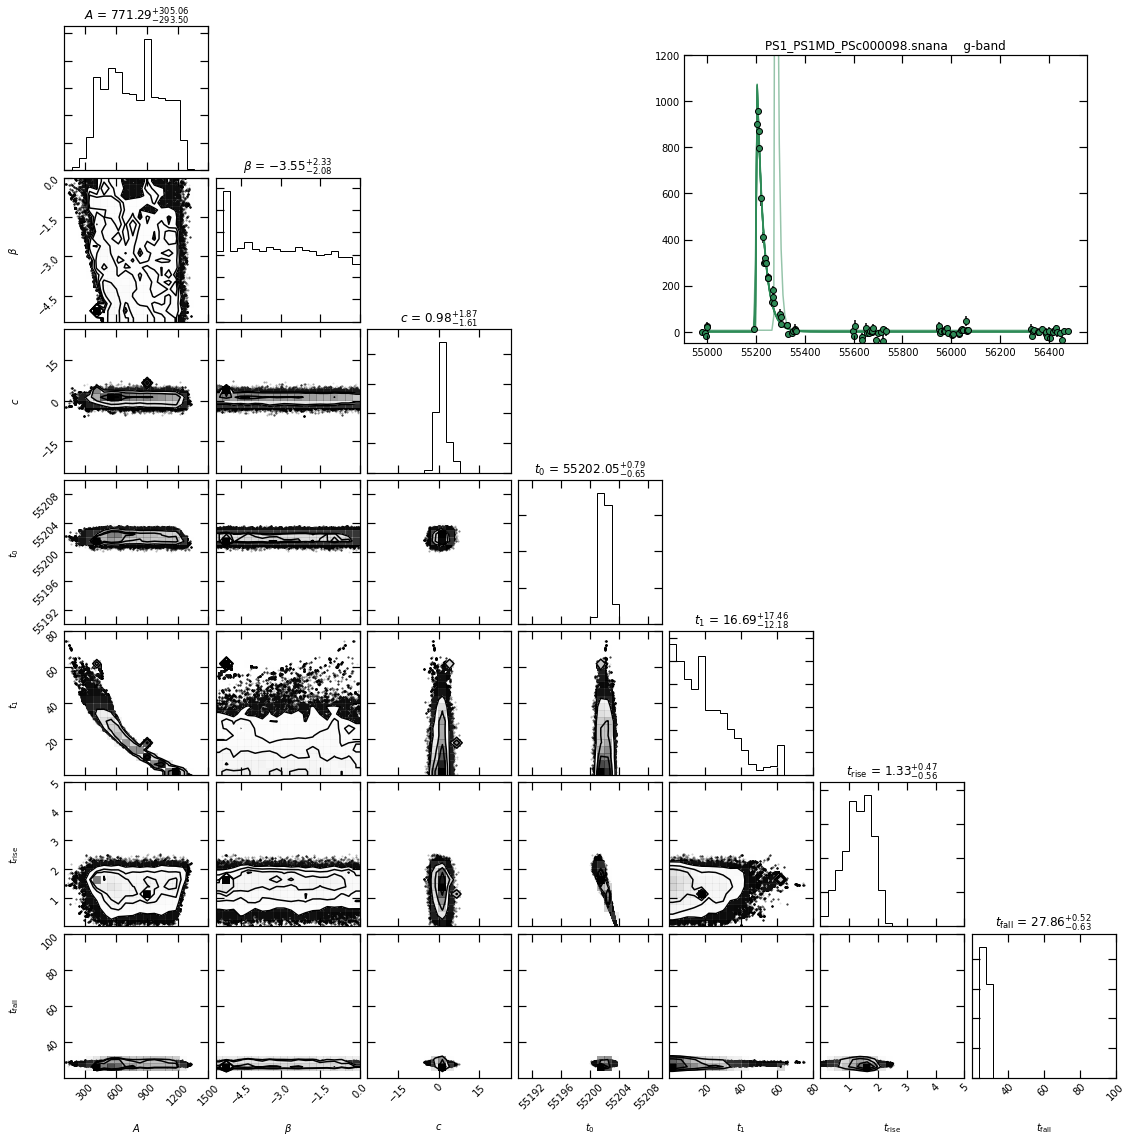

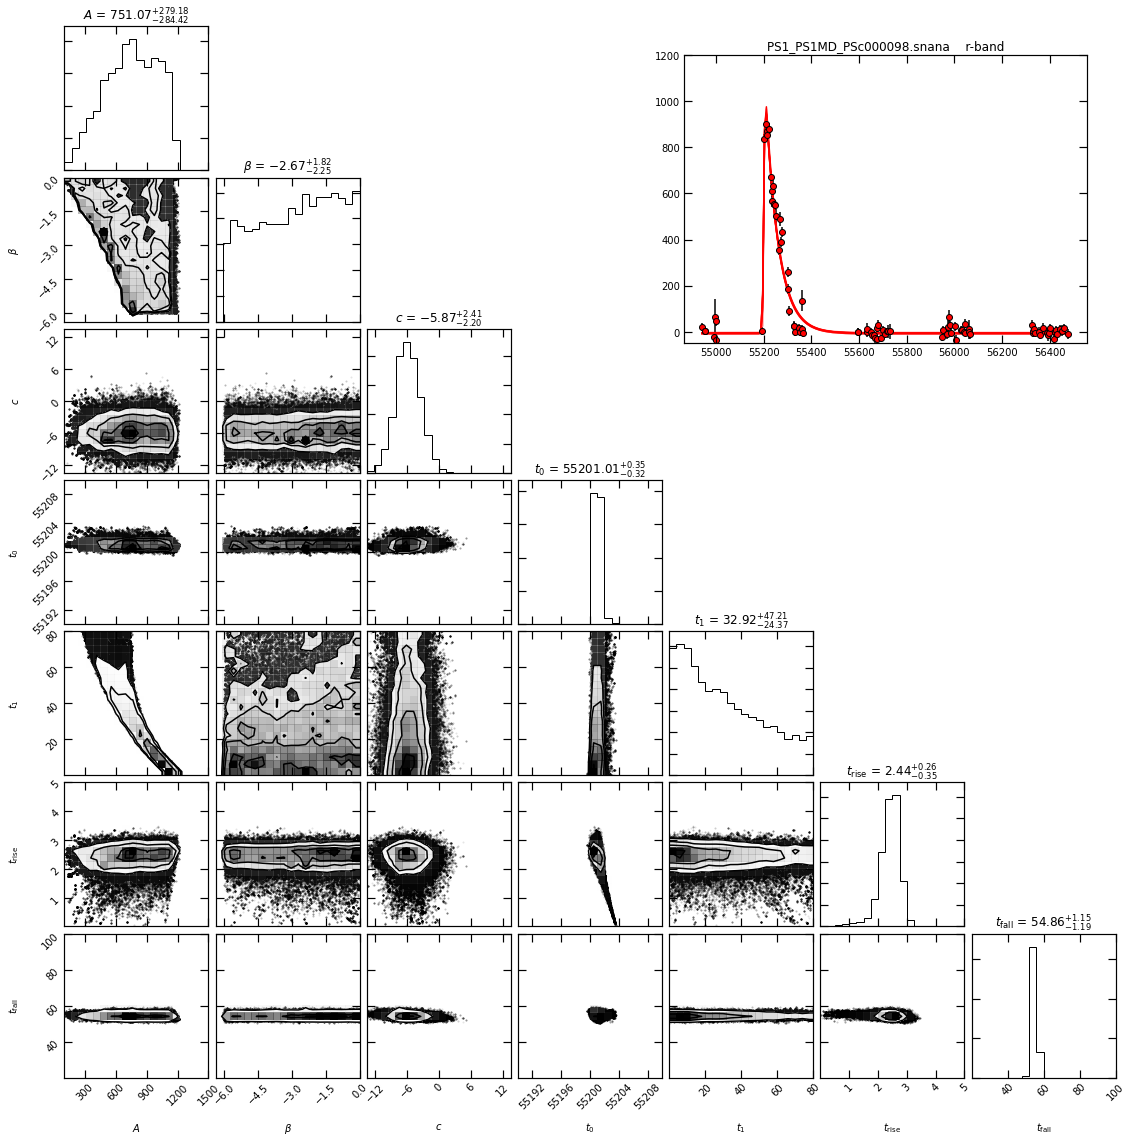

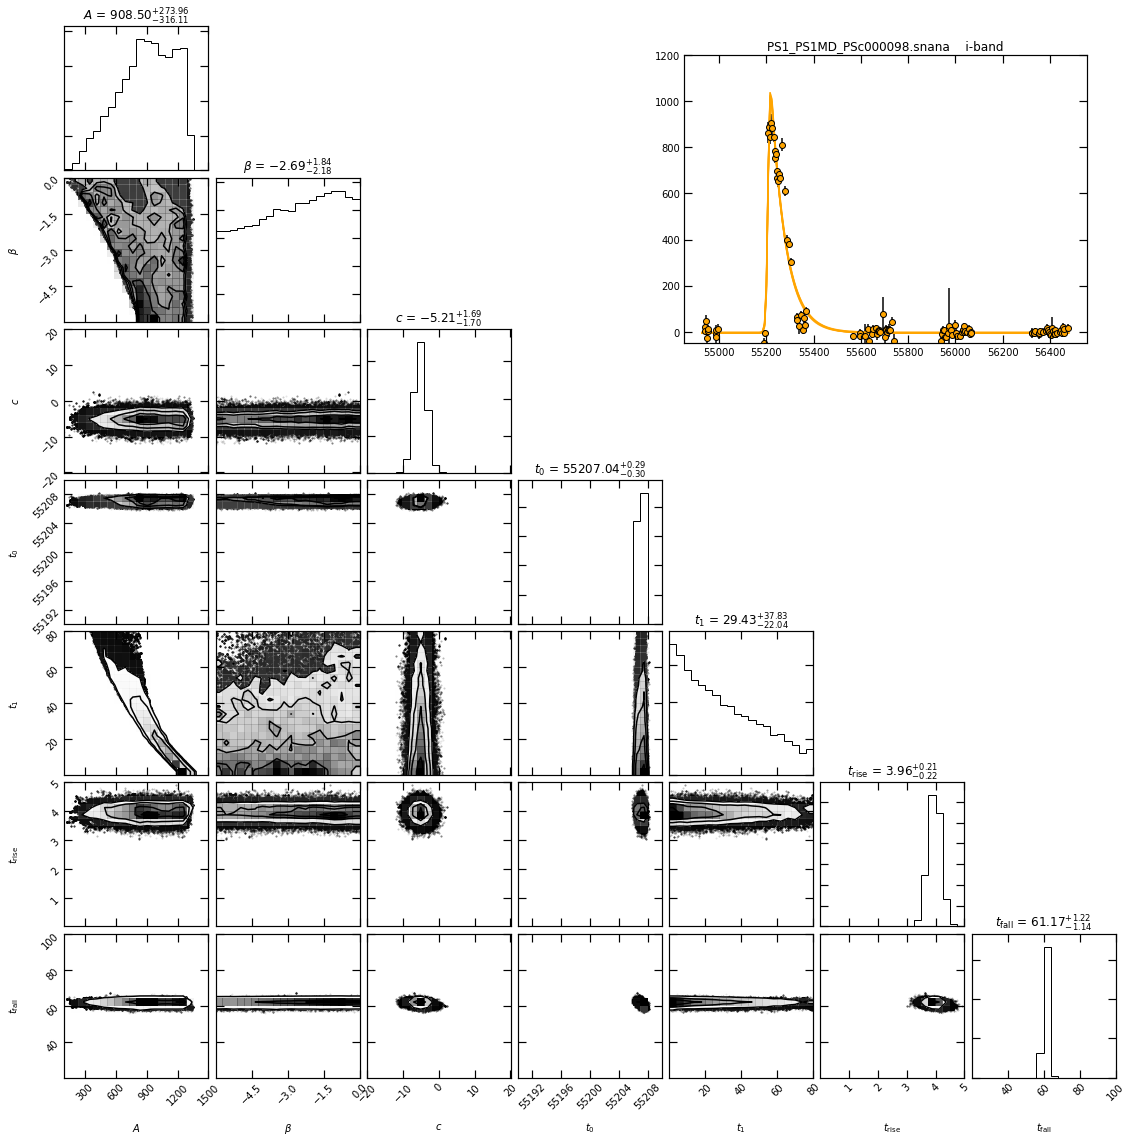

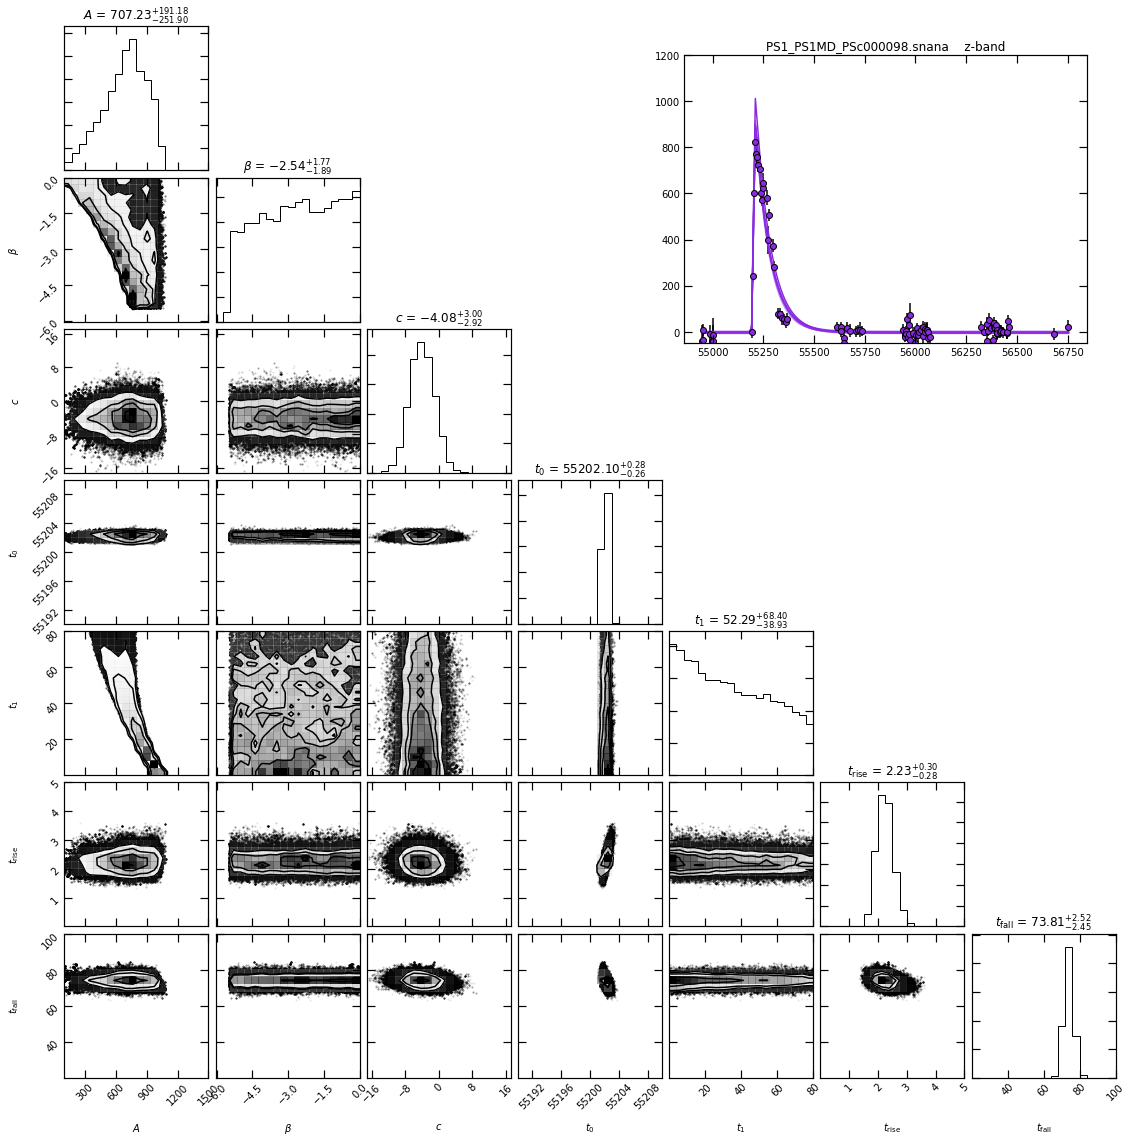

In [8]:
for bd in range(len(band_arr)):
    # plot the posterior by corner
    figure = corner.corner(saved_samples_arr1[bd,:,:], #quantiles=[0.16, 0.5, 0.84], \
                       show_titles=True, labels=params_label, title_kwargs={"fontsize": 12},
                       range=((100, 1500), (-y.max()/150, 0), (-np.median(yerr), np.median(yerr)), \
                              (55190, 55210), (0, 80), (0,5), (20, 100)));
    
    # plot the recreated plot
    axes = figure.add_subplot(1,1,1)
    axes.set_position([0.6, 0.7, 0.35, 0.25])
    axes.set_title('PS1_PS1MD_PSc000098.snana    '+band_arr[bd]+'-band')
    x, y, yerr = get_data('./PS1_PS1MD_PSc000098.snana.dat', band_arr[bd])
    axes.errorbar(x, y, yerr=yerr, fmt='o', mfc=band_color[bd], mec='k', ecolor='k', label=band_arr[bd]+'-band')
    ## randomly choose 10 sets of parameters to plot
    plot_x = np.linspace(x.min(), x.max(), 200)
    for i in range(10):
        axes.plot(plot_x, Flux_model(plot_x, saved_samples_arr1[bd, np.random.choice((nsteps-nburn)*nwalkers), :]), c=band_color[bd], alpha=0.5) 
    ## plot the fitted line from the median parameters
    axes.plot(plot_x, Flux_model(plot_x, saved_median_params1[bd, :]), c=band_color[bd], ls='-')
    axes.set_ylim(-50, 1200)

Text(0, 0.5, 'flux')

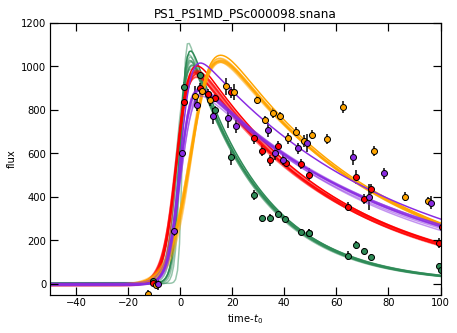

In [14]:
fig,axes = plt.subplots(1,1,figsize=(7,5))
axes.set_title('PS1_PS1MD_PSc000098.snana')
for bd in range(len(band_arr)):
    # plot the recreated plot
    x, y, yerr = get_data('./PS1_PS1MD_PSc000098.snana.dat', band_arr[bd])
    axes.errorbar(x-saved_median_params1[0, 3], y, yerr=yerr, fmt='o', mfc=band_color[bd], mec='k', ecolor='k', label=band_arr[bd]+'-band')
    ## randomly choose 10 sets of parameters to plot
    plot_x = np.linspace(saved_median_params1[0, 3]-50, saved_median_params1[0, 3]+100, 200)
    for i in range(10):
        axes.plot(plot_x-saved_median_params1[0, 3], Flux_model(plot_x, saved_samples_arr1[bd, np.random.choice((nsteps-nburn)*nwalkers), :]), c=band_color[bd], alpha=0.5) 
    axes.plot(plot_x-saved_median_params1[0, 3], Flux_model(plot_x, saved_median_params1[bd, :]), c=band_color[bd], ls='-')
axes.set_ylim(-50, 1200)
axes.set_xlim(-50, 100)
axes.set_xlabel('time-$t_0$')
axes.set_ylabel('flux')

In [13]:
# Report the auto-correlation length
#Thin it by a factor of 10 and report the auto-correlation length 

# for each band
for bd in range(len(band_arr)):
    print('-------------------------------\nfor '+band_arr[bd]+'-band')
    # for each parameter
    for tt in range(ndim):
        print('parameter: ', params_label[tt])
        for k in range(1, nsteps-nburn):
            s_all = pd.Series(saved_samples_arr1[bd, :nsteps-nburn, tt])
            ac_all = s_all.autocorr(lag=k)
            # when the autocorrelation value close to 0, set that lag to be the autocorrelation length
            if ac_all<0.01: 
                # report the length
                print('autocorrelation length: %d'%(k))
                break
        for k in range(1, nsteps-nburn):
            s_thin = pd.Series(saved_samples_arr1[bd, :nsteps-nburn:10, tt]) # thin the chain by 10
            ac_thin = s_thin.autocorr(lag=k)
            if ac_thin<0.01:
                print('autocorrelation length (thinned): %d'%(k))
                break
        print()
    print('-------------------------------')

-------------------------------
for g-band
parameter:  $A$
autocorrelation length: 2401
autocorrelation length (thinned): 241

parameter:  $\beta$
autocorrelation length: 1003
autocorrelation length (thinned): 101

parameter:  $c$
autocorrelation length: 1201
autocorrelation length (thinned): 121

parameter:  $t_0$
autocorrelation length: 505
autocorrelation length (thinned): 52

parameter:  $t_1$
autocorrelation length: 2406
autocorrelation length (thinned): 242

parameter:  $t_{\rm rise}$
autocorrelation length: 522
autocorrelation length (thinned): 53

parameter:  $t_{\rm fall}$
autocorrelation length: 1222
autocorrelation length (thinned): 61

-------------------------------
-------------------------------
for r-band
parameter:  $A$
autocorrelation length: 1610
autocorrelation length (thinned): 161

parameter:  $\beta$
autocorrelation length: 1448
autocorrelation length (thinned): 145

parameter:  $c$
autocorrelation length: 811
autocorrelation length (thinned): 81

parameter:  $t_

## for object: PS1_PS1MD_PSc000174.snana

In [15]:
saved_samples_arr2 = np.zeros((4, nwalkers*(nsteps-nburn), ndim))
saved_median_params2 = np.zeros((4, ndim))

for bd in range(len(band_arr)):
    x, y, yerr = get_data('./PS1_PS1MD_PSc000174.snana.dat', band_arr[bd])
    # Maximum likelihood estimation
    theta = np.array([350., -2., 0, 55200, 15., 5, 50])# A, beta, c, t0, t1, trise, tfall = theta
    it = 0
    while it < 100:
        initial = theta + np.array([100., 3., 10, 50., 20., 8., 50.]) * np.random.randn(len(theta))
        soln = minimize(nll, initial, args=(x, y, yerr), \
                        bounds=((0, 10*y.max()), (-y.max()/150,0.), (-3*yerr.mean(), 3*yerr.mean()), \
                                (x.min()-30, x.max()+300), (0, 200), (0.01, 50), (1, 100)))
        rchi2 = np.sum(((y-Flux_model(x, soln.x))/yerr)**2)/(len(x)-7+1)
        it += 1
        if rchi2 < 6.:
            break
    theta = soln.x
    # MCMC
    starting_guesses = np.zeros((nwalkers, ndim)) # A, beta, c, t0, t1, trise, tfall
    starting_guesses[:, 0] = np.random.normal(theta[0], 50, nwalkers) 
    starting_guesses[:, 1] = np.random.normal(theta[1], 1, nwalkers) 
    starting_guesses[:, 2] = np.random.normal(0, np.median(yerr), (nwalkers))
    starting_guesses[:, 3] = np.random.normal(theta[3], 10, nwalkers) 
    starting_guesses[:, 4] = 2/3.*np.random.normal(5, 5, (nwalkers))+1/3.*np.random.normal(60, 30, (nwalkers)) 
    starting_guesses[:, 5] = np.random.normal(theta[5], 1, nwalkers) 
    starting_guesses[:, 6] = np.random.normal(theta[6], 5, nwalkers)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y, yerr])
    _ = sampler.run_mcmc(starting_guesses, nsteps, progress=True)
    samples = sampler.chain[:, nburn:, :].reshape(-1, ndim)
    saved_samples_arr2[bd, :, :] = samples
    saved_median_params2[bd, :] = np.median(samples, axis=0)

100%|██████████| 25000/25000 [02:00<00:00, 207.85it/s]


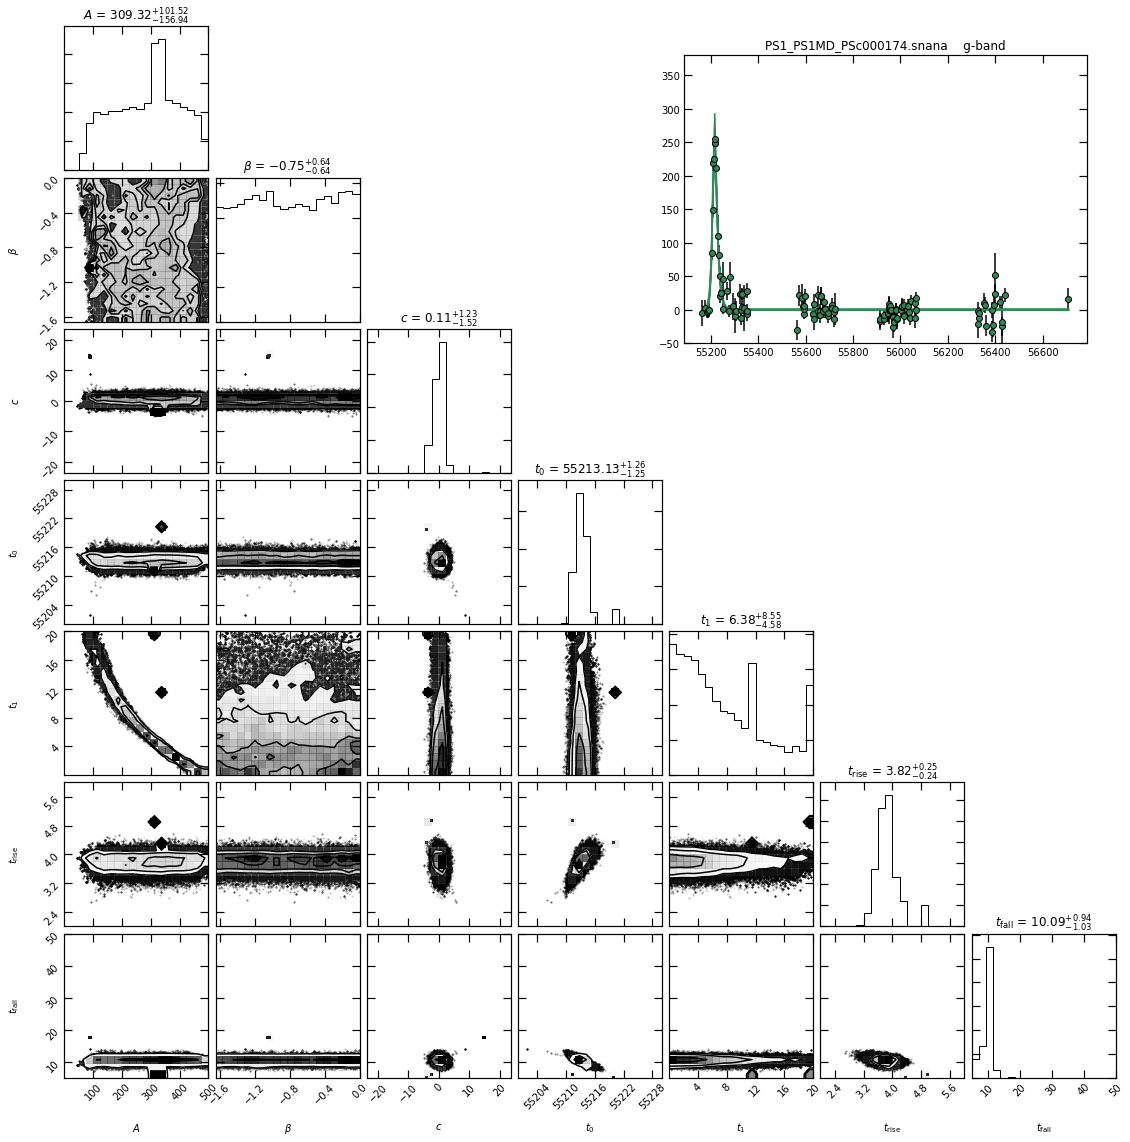

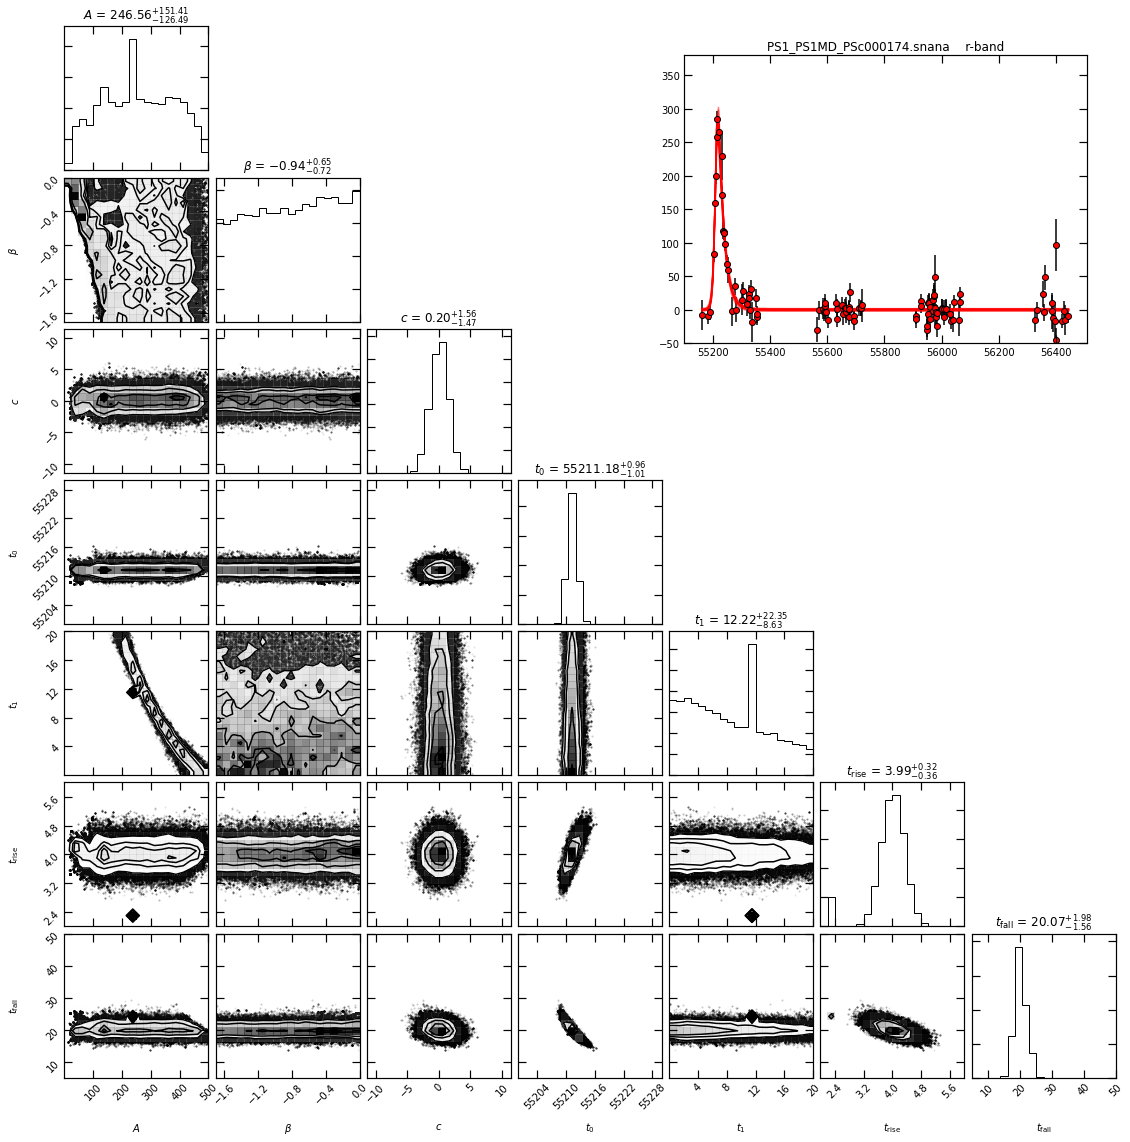

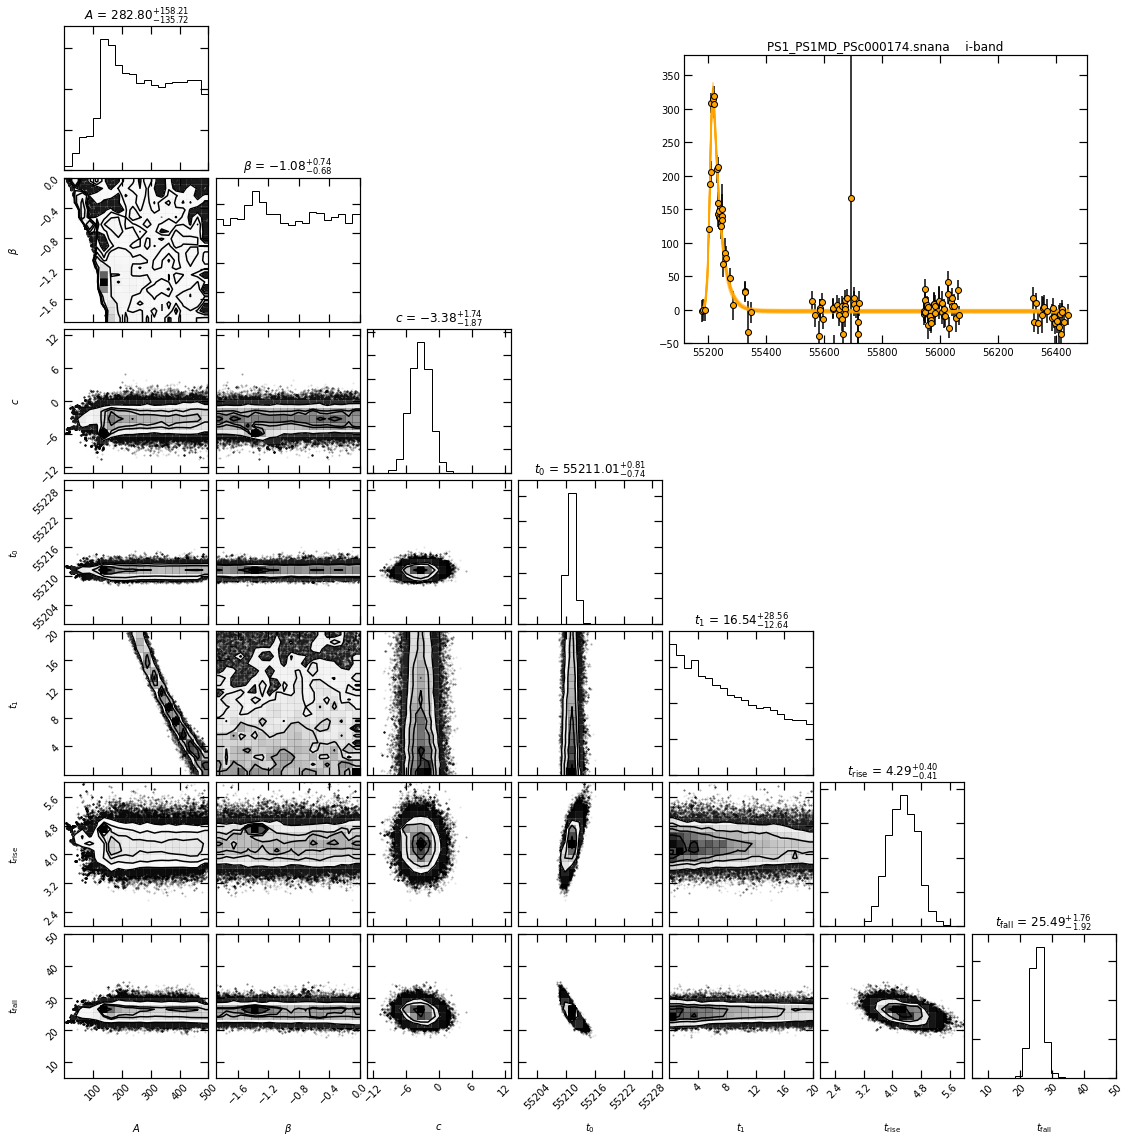

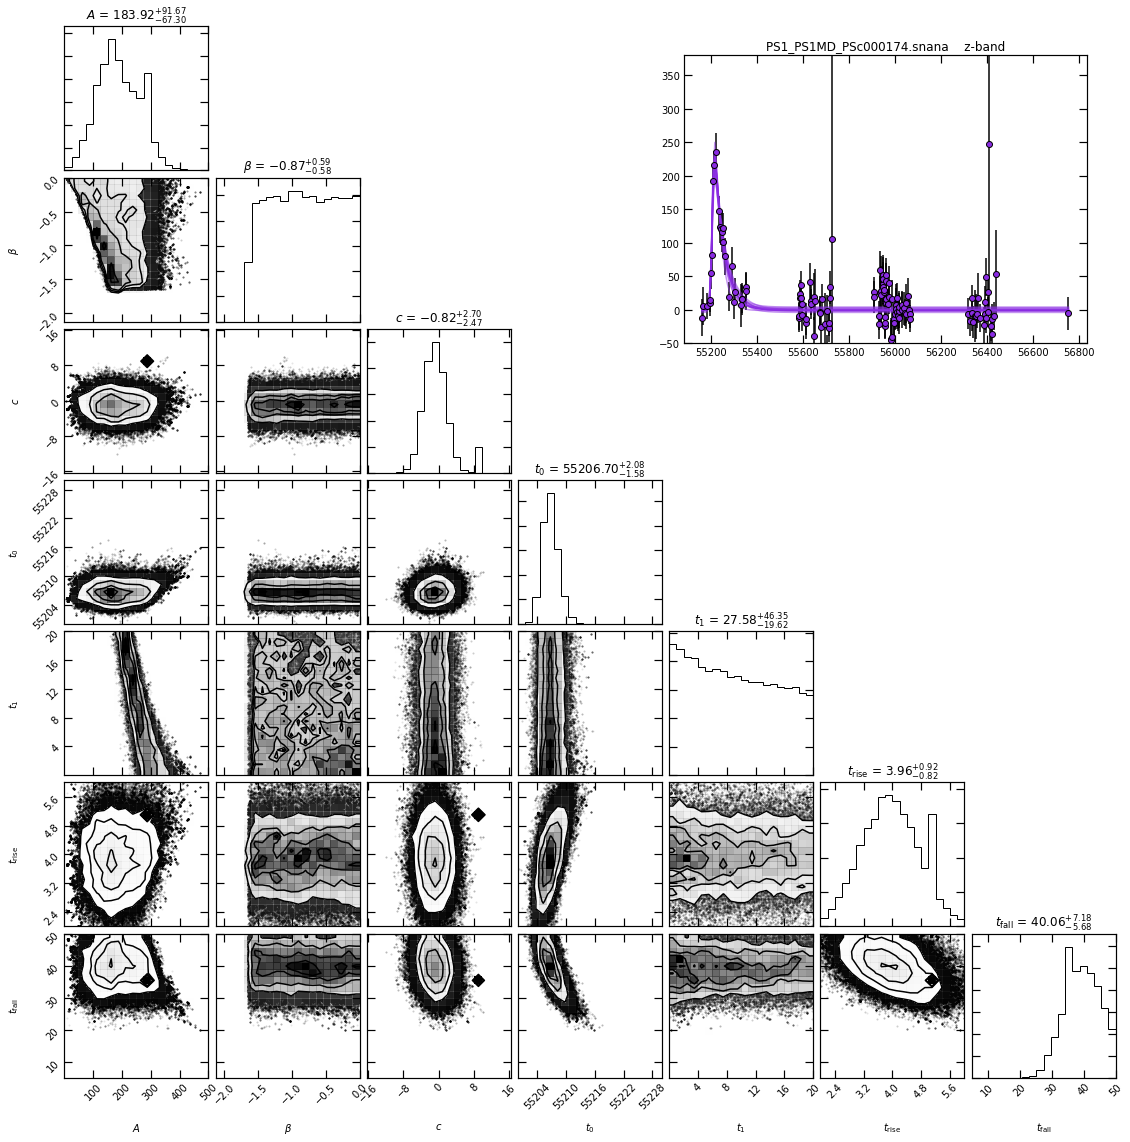

In [16]:
for bd in range(len(band_arr)):
    figure = corner.corner(saved_samples_arr2[bd, :, :], #quantiles=[0.16, 0.5, 0.84], \
                       show_titles=True, labels=params_label, title_kwargs={"fontsize": 12},
                       range=((0, 500), (-y.max()/150, 0), (-np.median(yerr), np.median(yerr)), \
                              (55200, 55230), (0, 20), (2,6), (5, 50)));
    axes = figure.add_subplot(1,1,1)
    axes.set_position([0.6, 0.7, 0.35, 0.25])
    axes.set_title('PS1_PS1MD_PSc000174.snana    '+band_arr[bd]+'-band')
    x, y, yerr = get_data('./PS1_PS1MD_PSc000174.snana.dat', band_arr[bd])
    plot_x = np.linspace(x.min(), x.max(), 200)
    axes.errorbar(x, y, yerr=yerr, fmt='o', mfc=band_color[bd], mec='k', ecolor='k', label=band_arr[bd]+'-band')
    for i in range(10):
        axes.plot(plot_x, Flux_model(plot_x, saved_samples_arr2[bd, np.random.choice((nsteps-nburn)*nwalkers), :]), c=band_color[bd], alpha=0.5) 
    axes.plot(plot_x, Flux_model(plot_x, saved_median_params2[bd, :]), c=band_color[bd], ls='-')
    axes.set_ylim(-50, 380)

Text(0, 0.5, 'flux')

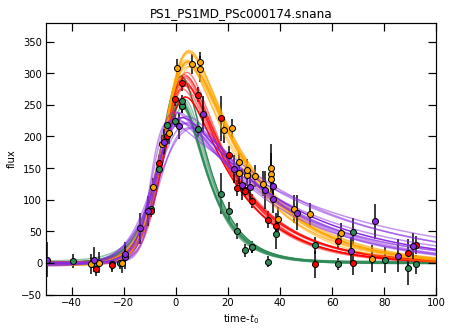

In [17]:
fig,axes = plt.subplots(1,1,figsize=(7,5))
axes.set_title('PS1_PS1MD_PSc000174.snana')
for bd in range(len(band_arr)):
    # plot the recreated plot
    x, y, yerr = get_data('./PS1_PS1MD_PSc000174.snana.dat', band_arr[bd])
    axes.errorbar(x-saved_median_params2[0, 3], y, yerr=yerr, fmt='o', mfc=band_color[bd], mec='k', ecolor='k', label=band_arr[bd]+'-band')
    ## randomly choose 10 sets of parameters to plot
    plot_x = np.linspace(saved_median_params2[0, 3]-50, saved_median_params2[0, 3]+100, 200)
    for i in range(10):
        axes.plot(plot_x-saved_median_params2[0, 3], Flux_model(plot_x, saved_samples_arr2[bd, np.random.choice((nsteps-nburn)*nwalkers), :]), c=band_color[bd], alpha=0.5) 
    axes.plot(plot_x-saved_median_params2[0, 3], Flux_model(plot_x, saved_median_params2[bd, :]), c=band_color[bd], ls='-')
axes.set_ylim(-50, 380)
axes.set_xlim(-50, 100)
axes.set_xlabel('time-$t_0$')
axes.set_ylabel('flux')

In [11]:
# Report the auto-correlation length
#Thin it by a factor of 10 and report the auto-correlation length 

for bd in range(len(band_arr)):
    print('-------------------------------\nfor '+band_arr[bd]+'-band')
    for tt in range(ndim):
        print('parameter: ', params_label[tt])
        for k in range(1, nsteps-nburn):
            s_all = pd.Series(saved_samples_arr2[bd, :nsteps-nburn, tt])
            ac_all = s_all.autocorr(lag=k)
            if ac_all<0.01:
                print('autocorrelation length: %d'%(k))
                break
        for k in range(1, nsteps-nburn):
            s_thin = pd.Series(saved_samples_arr2[bd, :nsteps-nburn:10, tt])
            ac_thin = s_thin.autocorr(lag=k)
            if ac_thin<0.01:
                print('autocorrelation length (thinned): %d'%(k))
                break
        print()
    print('-------------------------------')

-------------------------------
for g-band
parameter:  $A$
autocorrelation length: 1760
autocorrelation length (thinned): 177

parameter:  $\beta$
autocorrelation length: 470
autocorrelation length (thinned): 47

parameter:  $c$
autocorrelation length: 572
autocorrelation length (thinned): 71

parameter:  $t_0$
autocorrelation length: 950
autocorrelation length (thinned): 94

parameter:  $t_1$
autocorrelation length: 1653
autocorrelation length (thinned): 166

parameter:  $t_{\rm rise}$
autocorrelation length: 272
autocorrelation length (thinned): 27

parameter:  $t_{\rm fall}$
autocorrelation length: 848
autocorrelation length (thinned): 85

-------------------------------
-------------------------------
for r-band
parameter:  $A$
autocorrelation length: 1685
autocorrelation length (thinned): 168

parameter:  $\beta$
autocorrelation length: 540
autocorrelation length (thinned): 55

parameter:  $c$
autocorrelation length: 733
autocorrelation length (thinned): 74

parameter:  $t_0$
auto